In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
data_path = '../data'

In [4]:
train_image_path = os.path.join(data_path, 'train')
test_image_path = os.path.join(data_path, 'test')

In [5]:
train_table = pd.read_csv("../data/train.csv")

In [6]:
train_file_paths = glob.glob(os.path.join(data_path, 'train', '*'))

In [7]:
train_table.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


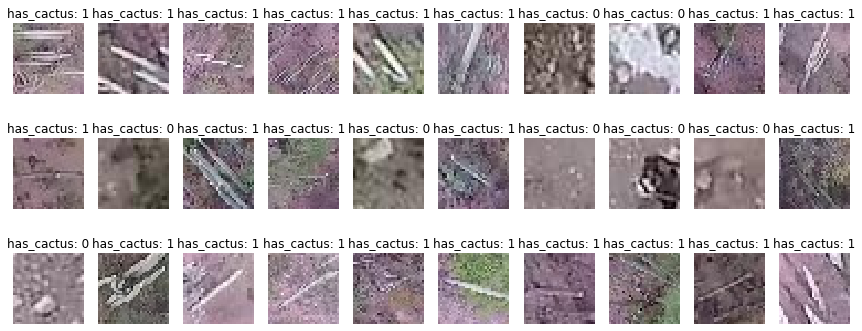

In [8]:
fig, ax = plt.subplots(3,10, figsize=(15, 6))
r = 0
c = 0
for idx in train_table.index[:30]:
    arr_img = np.array(Image.open(os.path.join(data_path, "train", train_table.loc[idx, "id"])))
    ax[r, c].imshow(arr_img)
    ax[r, c].set_title("has_cactus: " + str(train_table.loc[idx, "has_cactus"]))
    ax[r, c].axis("off")
    c += 1
    if c % 10 == 0:
        c = 0
        r += 1

In [9]:
arr_img.shape

(32, 32, 3)

### preprocessing

In [10]:
def preprocessing(img):
    img = Image.open(img)
    img_grey = img.convert('L')
    
    return img_grey

In [11]:
im = preprocessing(os.path.join(train_image_path, train_table.loc[1, "id"]))

In [12]:
np.array(im)

array([[112, 102,  98, ..., 141, 121, 106],
       [127, 117, 111, ..., 118, 102,  99],
       [144, 119, 101, ...,  82,  86, 108],
       ...,
       [195, 202, 217, ..., 177, 200, 237],
       [101, 110, 121, ..., 105, 132, 175],
       [ 83,  57,  52, ...,  96,  87, 116]], dtype=uint8)

### modeling

In [13]:
train_table = train_table.sample(frac=1)

In [14]:
X, y = train_table["id"].values, train_table["has_cactus"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
class CactusDataset(Dataset):
    def __init__(self, X_train, X_test, y_train, y_test):
        self.dataset = {
            "train": (X_train, y_train, len(X_train)),
            "test": (X_test, y_test, len(y_test))
        }
        self.set_split(split="train")
        
    def set_split(self, split="train"):
        self.split = split
        self.data_x, self.data_y, self.length = self.dataset[split]
    
    def preprocessing(self, filename):
        path = os.path.join(train_image_path, filename)
        img = Image.open(path)
            
        img_grey = img.convert('L')
        im_arr = np.array(img_grey) / 255
        
        return im_arr
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.preprocessing(self.data_x[idx])).unsqueeze(0)
        y = torch.FloatTensor([self.data_y[idx]])
        
        return x, y

    def __len__(self):
        return self.length

In [17]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(1, 1, 3),
            nn.ReLU(),
            nn.Conv2d(1, 1, 3),
            nn.ReLU(),
            nn.Conv2d(1, 1, 3),
            nn.ReLU(),
            nn.Conv2d(1, 1, 3),
            nn.ReLU(),
            nn.Conv2d(1, 1, 3),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc1 = nn.Linear(484, 128)
        self.fc2 = nn.Linear(128, 1)
        
    def forward(self, input_):
        out = self.network(input_)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

In [18]:
dataset = CactusDataset(X_train, X_test, y_train, y_test)

In [19]:
model = Classifier().to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.BCELoss()

In [21]:
## sum weight + bias
num_param = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_param}")

Total number of parameters: 62259


In [22]:
def compute_accuracy(y, out):
    out_indicies = (out > 0.5).long()
    y = y.long()
    n_correct = torch.eq(y, out_indicies).sum().item()
    accuracy = n_correct / y.shape[0]
    
    return accuracy * 100

In [23]:
for epoch in range(1, 101):
    
    running_loss = 0
    running_loss_v = 0
    running_acc = 0
    running_acc_v = 0
    
    dataset.set_split("train")
    data_gen = DataLoader(dataset, batch_size=128)
    model.train()
    for batch_index, (x, y) in enumerate(data_gen, 1):
        
        optimizer.zero_grad()
        
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        out = torch.sigmoid(out)
        
        loss = criterion(out, y)
        loss_train = loss.item()
        running_loss += (loss_train - running_loss) / batch_index
        
        accuracy = compute_accuracy(y, out)
        running_acc += (accuracy - running_acc) / batch_index
        
        loss.backward()
        
        optimizer.step()
    
    dataset.set_split("test")
    data_gen = DataLoader(dataset, batch_size=128)
    model.eval()
    for batch_index, (x, y) in enumerate(data_gen, 1):
        
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        out = torch.sigmoid(out)
        
        loss = criterion(out, y)
        loss_train = loss.item()
        running_loss_v += (loss_train - running_loss_v) / batch_index
        
        accuracy = compute_accuracy(y, out)
        running_acc_v += (accuracy - running_acc_v) / batch_index
        
    print(f'epoch: {epoch}')
    print(f'\ttrain loss: {running_loss:.2f} | accuracy: {running_acc:.2f}')
    print(f'\tval loss: {running_loss_v:.2f} | accuracy: {running_acc_v:.2f}')

epoch: 1
	train loss: 0.57 | accuracy: 74.25
	val loss: 0.55 | accuracy: 76.45
epoch: 2
	train loss: 0.56 | accuracy: 74.73
	val loss: 0.54 | accuracy: 76.45
epoch: 3
	train loss: 0.50 | accuracy: 77.46
	val loss: 0.44 | accuracy: 84.00
epoch: 4
	train loss: 0.45 | accuracy: 82.86
	val loss: 0.41 | accuracy: 84.98
epoch: 5
	train loss: 0.40 | accuracy: 84.40
	val loss: 0.34 | accuracy: 87.59
epoch: 6
	train loss: 0.32 | accuracy: 86.86
	val loss: 0.27 | accuracy: 89.21
epoch: 7
	train loss: 0.28 | accuracy: 88.74
	val loss: 0.25 | accuracy: 89.91
epoch: 8
	train loss: 0.26 | accuracy: 89.37
	val loss: 0.24 | accuracy: 90.10
epoch: 9
	train loss: 0.26 | accuracy: 89.58
	val loss: 0.24 | accuracy: 90.27
epoch: 10
	train loss: 0.25 | accuracy: 89.72
	val loss: 0.24 | accuracy: 90.33
epoch: 11
	train loss: 0.25 | accuracy: 89.88
	val loss: 0.24 | accuracy: 90.55
epoch: 12
	train loss: 0.25 | accuracy: 90.00
	val loss: 0.23 | accuracy: 90.66
epoch: 13
	train loss: 0.25 | accuracy: 90.07
	va